In [74]:
# Utilities
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
from collections import Counter

# Plotting
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Modelling
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

RSEED = 42

In [75]:
df = pd.read_csv("data/data_train_clean_withdummies.csv")

In [43]:
df.head()

,TransactionId,AccountId,SubscriptionId,CustomerId,Value,FraudResult,ISOWeek,TransactionInBatch,value_amount_diff,TransactionsToDate,...,DayTime_midday,DayTime_morning,DayTime_night,TransactionWeekday_2,TransactionWeekday_3,TransactionWeekday_4,TransactionWeekday_5,TransactionWeekday_6,TransactionWeekday_7,DebitCredit_1
0,76871,3957,887,4406,1000,0,46,1,0.0,0,...,0,0,1,0,0,1,0,0,0,0
1,73770,4841,3829,4406,20,0,46,1,40.0,0,...,0,0,1,0,0,1,0,0,0,1
2,26203,4229,222,4683,500,0,46,1,0.0,0,...,0,0,1,0,0,1,0,0,0,0
3,380,648,2185,988,21800,0,46,1,1800.0,0,...,0,0,1,0,0,1,0,0,0,0
4,28195,4841,3829,988,644,0,46,1,1288.0,1,...,0,0,1,0,0,1,0,0,0,1


### Splitting the data

In [76]:
#separate predictor variables
X = df.drop('FraudResult', axis =1)

# separate target variable
y = df['FraudResult']


In [77]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RSEED)

### Data Balance - Oversampling

*Usefull links*:
- [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html)
- [Handling Imbalanced Data Sets, Medium](https://medium.com/coinmonks/handling-imbalanced-datasets-predicting-credit-card-fraud-544f5e74e0fd)
- [Dealing with imbalanced Data, towardsdatascience](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

In [78]:
# apply resampling ONLY to train data
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

In [47]:
y_train_res

0         0
1         0
2         0
3         0
4         0
         ..
152741    1
152742    1
152743    1
152744    1
152745    1
Name: FraudResult, Length: 152746, dtype: int64

In [79]:
scaler = StandardScaler()

#standardization of train set (fit_transform)
X_train_res_stand = scaler.fit_transform(X_train_res)

#change array to dataframe
scaled_df_train_resampled = pd.DataFrame(X_train_res_stand)
scaled_df_train_resampled.columns = X_train.columns

#standardization of test set (transform)
X_test_stand = scaler.transform(X_test)

#change array to dataframe
scaled_df_test = pd.DataFrame(X_test_stand)
scaled_df_test.columns = X_test.columns

In [49]:
#scaled_df_resampled

---

## Base Line Model

The following code for the classifier comparison was taken from [Machine Learning Mastery](https://machinelearningmastery.com/naive-classifiers-imbalanced-classification-metrics/).

>Uniform 0.500 (0.005)
>Stratified 0.500 (0.004)
>Majority 0.200 (0.305)
>Minority 0.667 (0.000)
>Prior 0.200 (0.305)


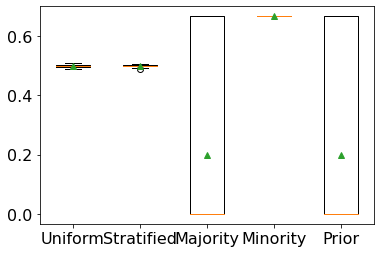

In [80]:
# compare naive classifiers with f1-measure
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
	return scores

# define models to test
def get_models():
	models, names = list(), list()
	# Uniformly Random Guess
	models.append(DummyClassifier(strategy='uniform'))
	names.append('Uniform')
	# Prior Random Guess
	models.append(DummyClassifier(strategy='stratified'))
	names.append('Stratified')
	# Majority Class: Predict 0
	models.append(DummyClassifier(strategy='most_frequent'))
	names.append('Majority')
	# Minority Class: Predict 1
	models.append(DummyClassifier(strategy='constant', constant=1))
	names.append('Minority')
	# Class Prior
	models.append(DummyClassifier(strategy='prior'))
	names.append('Prior')
	return models, names

# define dataset
"""
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
"""
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(scaled_df_train_resampled, y_train_res, models[i])
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Results:

The 'Minority' `DummyClassifier` seems to deliver the best result (0.667) for a naive classifier with regards to the f1 score metric which is our goal.

In [81]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(scaled_df_train_resampled, y_train_res)

y_dummy_pred = dummy_clf.predict(scaled_df_train_resampled)

In [82]:
print("------"*10)
print(classification_report(y_train_res, y_dummy_pred))
print("------"*10)

# F1-score on test set
print("F1-score:", f1_score(y_train_res, y_dummy_pred, average='binary'))
print("------"*10)

f1_baseline = f1_score(y_train_res, y_dummy_pred, average='binary')

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     76373
           1       0.50      1.00      0.67     76373

    accuracy                           0.50    152746
   macro avg       0.25      0.50      0.33    152746
weighted avg       0.25      0.50      0.33    152746

------------------------------------------------------------
F1-score: 0.6666666666666666
------------------------------------------------------------


/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

## Modelling

### First Models

1. SVM ==> Daniela
2. LogReg ==> Kai Yang

### Advanced Models

1. Random Forest ==> Fabio
2. AdaBoost ==> 
3. Stacking ==> 

In [53]:
# save TRAIN sets
scaled_df_train_resampled.to_csv('data/x-train.csv', index=False)
y_train_res.to_csv('data/y-train.csv', index=False)

# save TEST sets
scaled_df_test.to_csv('data/x-test.csv', index=False)
y_test.to_csv('data/y-test.csv', index=False)

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [55]:
# Random Forest =================================
# Make a decision tree and train
tree = DecisionTreeClassifier(max_depth= None, random_state=RSEED)
tree.fit(scaled_df_train_resampled, y_train_res)

y_tree_pred = tree.predict(scaled_df_test)

In [56]:
y_tree_pred.shape

(19133,)

In [57]:
y_test.shape

(19133,)

In [58]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(scaled_df_train_resampled, y_train_res)}')
print(f'Model F1-Score: {f1_score(y_test, y_tree_pred, average="binary")}')


Decision tree has 257 nodes with maximum depth 22.
Model Accuracy: 1.0
Model F1-Score: 0.8157894736842105


---

#### Random Forest

In [59]:
# optimal params: n_estimators=1000, criterion=entropy, max_features=sqrt
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               criterion = 'entropy',
                               max_features = 'sqrt',
                               max_depth = None,
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(scaled_df_train_resampled, y_train_res)
y_rf_pred = model.predict(scaled_df_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [60]:
print("------"*10)
print(classification_report(y_test, y_rf_pred))
print("------"*10)

# F1-score on test set
print(f'Model F1-Score: {f1_score(y_test, y_rf_pred, average="binary")}')
print("------"*10)
print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_rf_pred))

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19096
           1       0.86      0.97      0.91        37

    accuracy                           1.00     19133
   macro avg       0.93      0.99      0.96     19133
weighted avg       1.00      1.00      1.00     19133

------------------------------------------------------------
Model F1-Score: 0.9113924050632912
------------------------------------------------------------
Confusion Matrix: 
 [[19090     6]
 [    1    36]]


---

### Feature Importance (Random Forest)

In [99]:
np.transpose(np.asarray(model.feature_importances_))

array([4.01312475e-03, 3.61758842e-02, 1.52619860e-02, 1.46763524e-02,
       3.03807626e-01, 1.82933014e-02, 5.88196487e-04, 1.25581233e-02,
       2.39375222e-02, 2.46985030e-01, 4.03070618e-06, 3.17662409e-03,
       2.24541526e-02, 1.05151901e-02, 6.13343116e-02, 6.96211048e-06,
       2.10317300e-02, 7.57694393e-04, 3.29463862e-05, 2.09929519e-02,
       1.94127308e-04, 1.26626604e-05, 9.65474720e-06, 1.17601587e-02,
       1.38360363e-04, 0.00000000e+00, 4.70523122e-05, 3.08042240e-04,
       4.53614826e-02, 1.38031374e-08, 8.51180468e-05, 4.58895817e-04,
       5.51602170e-04, 1.56924031e-05, 6.96587319e-09, 2.52594991e-05,
       4.28618532e-07, 2.35771587e-04, 1.78839590e-02, 2.62610699e-05,
       0.00000000e+00, 5.63900938e-04, 3.41808191e-05, 4.89582752e-04,
       5.73955589e-04, 1.57802963e-02, 1.01388264e-02, 1.22569156e-04,
       1.74387459e-03, 9.21371689e-03, 1.09402559e-02, 2.01694217e-03,
       3.62597219e-03, 6.89345431e-03, 7.29593862e-04, 2.12097054e-03,
      

In [101]:
x=np.asarray(model.feature_importances_)
print(np.array_str(x, precision=2, suppress_small=True))
print(model.feature_names_in_)
df_feat = pd.DataFrame(x, columns= ['Importance'],index=model.feature_names_in_)

[0.   0.04 0.02 0.01 0.3  0.02 0.   0.01 0.02 0.25 0.   0.   0.02 0.01
 0.06 0.   0.02 0.   0.   0.02 0.   0.   0.   0.01 0.   0.   0.   0.
 0.05 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.
 0.   0.   0.   0.02 0.01 0.   0.   0.01 0.01 0.   0.   0.01 0.   0.
 0.   0.   0.01 0.   0.   0.02]
['TransactionId' 'AccountId' 'SubscriptionId' 'CustomerId' 'Value'
 'ISOWeek' 'TransactionInBatch' 'value_amount_diff' 'TransactionsToDate'
 'ValueLog' 'ProviderId_2' 'ProviderId_3' 'ProviderId_4' 'ProviderId_5'
 'ProviderId_6' 'ProductId_2' 'ProductId_3' 'ProductId_4' 'ProductId_5'
 'ProductId_6' 'ProductId_7' 'ProductId_8' 'ProductId_9' 'ProductId_10'
 'ProductId_11' 'ProductId_12' 'ProductId_13' 'ProductId_14'
 'ProductId_15' 'ProductId_16' 'ProductId_19' 'ProductId_20'
 'ProductId_21' 'ProductId_22' 'ProductId_23' 'ProductId_24'
 'ProductId_27' 'ProductCategory_data_bundles'
 'ProductCategory_financial_services' 'ProductCategory_movies'
 'ProductCategory_other' 'ProductCategory

In [102]:
df_feat

,Importance
TransactionId,0.004013
AccountId,0.036176
SubscriptionId,0.015262
CustomerId,0.014676
Value,0.303808
...,...
TransactionWeekday_4,0.001265
TransactionWeekday_5,0.013025
TransactionWeekday_6,0.002587
TransactionWeekday_7,0.002609


In [71]:
# GRID SEARCH ===========================

param_grid = {'max_features': ['sqrt'], 
              'criterion': ['gini', 'entropy'],
              'n_estimators': [500,600,700],
              'random_state': [10,42,112,13]
             }

grid       = GridSearchCV(RandomForestClassifier(), param_grid, verbose=True, n_jobs=-1,scoring='f1')
model_rf  = grid.fit(scaled_df_train_resampled, y_train_res)
y_rf_grid_pred = model_rf.predict(scaled_df_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [72]:
print("------"*10)
print(classification_report(y_test, y_rf_grid_pred))
print("------"*10)

# F1-score on test set 
print(f'Model F1-Score: {f1_score(y_test, y_rf_grid_pred, average="binary")}')
print("------"*10)
print(f'Model Matthew Corr: {matthews_corrcoef(y_test, y_rf_grid_pred)}')
print("------"*10)
print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_rf_grid_pred))

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19096
           1       0.88      0.97      0.92        37

    accuracy                           1.00     19133
   macro avg       0.94      0.99      0.96     19133
weighted avg       1.00      1.00      1.00     19133

------------------------------------------------------------
Model F1-Score: 0.923076923076923
------------------------------------------------------------
Model Matthew Corr: 0.9241411579910072
------------------------------------------------------------
Confusion Matrix: 
 [[19091     5]
 [    1    36]]


In [73]:
model_rf.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 500,
 'random_state': 42}

In [ ]:
y_train_rf_pred = model.predict(scaled_df_train_resampled)
train_rf_probs = model.predict_proba(scaled_df_train_resampled)[:, 1]

y_rf_pred = model.predict(scaled_df_test)
rf_probs = model.predict_proba(scaled_df_test)[:, 1]
evaluate_model(y_rf_pred, rf_probs, y_train_rf_pred, train_rf_probs)

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions)
    train_results['precision'] = precision_score(y_train_res, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
